In [ ]:
%pip install langchain
%pip install faiss-cpu    # or faiss-gpu if using GPU
%pip install boto3
%pip install langchain-community
%pip install PyMuPDF  # for text + image extraction

In [2]:
import fitz  # PyMuPDF
import base64
from IPython.display import display, Image

def extract_text_and_images(pdf_path):
    doc = fitz.open(pdf_path)
    pages = []

    for i, page in enumerate(doc):
        text = page.get_text()
        images = []

        for img in page.get_images(full=True):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_b64 = base64.b64encode(image_bytes).decode("utf-8")
            images.append({
                "base64": image_b64,
                "ext": base_image["ext"]
            })

        pages.append({
            "page_number": i,
            "text": text,
            "images": images
        })
    return pages


def display_base64_image(image_base64, image_ext):
  image_bytes = base64.b64decode(image_base64)
  display(Image(data=image_bytes, format=image_ext))



In [9]:
from langchain.embeddings import BedrockEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

def create_vector_store(pages):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = []

    for page in pages:
        for chunk in text_splitter.split_text(page["text"]):
            metadata = {"page_number": page["page_number"]}
            docs.append(Document(page_content=chunk, metadata=metadata))

    embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")
    vector_store = FAISS.from_documents(docs, embeddings)
    return vector_store

def retrieve_top_chunks(vector_store, query, k=3):
    return vector_store.similarity_search(query, k=k)

In [10]:

def build_prompt(query, documents, pages):
    context = ""
    added_pages = set()

    for doc in documents:
        page_num = doc.metadata["page_number"]
        context += f"Page {page_num}:\n{doc.page_content}\n\n"

        if page_num not in added_pages:
            images = pages[page_num]["images"]
            for img in images:
                context += f"![Image_Page_{page_num}](data:image/{img['ext']};base64,{img['base64']})\n\n"
            added_pages.add(page_num)

    return f"""
You are a helpful assistant answering questions from a printer manual.
Use the following context to answer:

{context}

User Question: {query}
"""


🔍 Extracting text and images...
📦 Creating vector store...
🤖 Ask me anything about the printer manual!



User:  how to insert cartridge?



Assistant: The manual provides the following instructions for inserting a print cartridge into the printer:

1. Open the print cartridge access door of the printer.

2. If you are replacing an existing cartridge, first remove it by pushing down and pulling outward on the cartridge in the cradle.

3. Remove the bright pink tape from the new cartridge. Do not touch the ink nozzles or copper-colored contacts.

4. Hold the new cartridge with the label on top and slide it into the cradle at a slight upward angle so the copper-colored contacts go in first. 

5. Push the cartridge until it snaps into place.

6. Close the print cartridge access door.

The key steps are:
- Open the access door
- Remove any existing cartridge 
- Remove the tape from the new cartridge
- Insert the new cartridge at an upward angle with contacts going in first
- Push it in until it snaps into the cradle
- Close the access door

Follow these steps carefully to properly install the new print cartridge. Let me know i

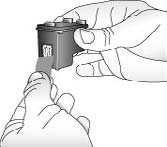


🖼️ Displaying image from Page 24


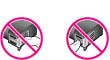


🖼️ Displaying image from Page 24


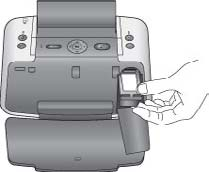


🖼️ Displaying image from Page 25


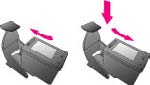


User:  exit


In [11]:
#from extract_pdf import extract_text_and_images
#from vector_store import create_vector_store, retrieve_top_chunks
#from prompt_builder import build_prompt

#from langchain.llms import Bedrock
from langchain_community.chat_models import BedrockChat
import sys
import time

import boto3
import os

os.environ["AWS_ACCESS_KEY_ID"] = "XXXXXXXXXXXX"
os.environ["AWS_SECRET_ACCESS_KEY"] = "XXXXXXXXXXXXXXXXXXX"
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

def main():
    # Step 1: Load PDF
    print("🔍 Extracting text and images...")
    file_path = "HP_printer_manual.pdf" 
    pages = extract_text_and_images(file_path)

    # Step 2: Vector Store
    print("📦 Creating vector store...")
    vector_store = create_vector_store(pages)

    # Step 3: Chat Loop
    llm = BedrockChat(model_id="anthropic.claude-3-sonnet-20240229-v1:0")
    print("🤖 Ask me anything about the printer manual!")

    while True:
        query = input("\nUser: ")
        if query.lower() in ["exit", "quit"]:
            break

        docs = retrieve_top_chunks(vector_store, query)
        prompt = build_prompt(query, docs, pages)
        response = llm.invoke(prompt)
        print("\nAssistant:", response.content)

     # Display images from relevant pages
        displayed_pages = set()
        for doc in docs:
          page_num = doc.metadata["page_number"]
          if page_num not in displayed_pages:
            images = pages[page_num]["images"]
            for img in images:
                print(f"\n🖼️ Displaying image from Page {page_num}")
                display_base64_image(img["base64"], img["ext"])
            displayed_pages.add(page_num)

        sys.stdout.flush()
        time.sleep(0.5)         

if __name__ == "__main__":
    main()